# JupyterHub Notebook

### This notebook server is hosted on the OpenShift platform which provides a separate server for each individual user. The platform takes care of the provisioning of the server and allocating related to storage.


## Introduction
Customer churn occurs when customers or subscribers stop doing business with a company or service, also known as customer attrition. It is also referred as loss of clients or customers. One industry in which churn rates are particularly useful is the telecommunications industry, because most customers have multiple options from which to choose within a geographic location.




In [96]:
import numpy as np 
import pandas as pd 
import eli5
import plotly
import plotly.graph_objs as go
import matplotlib.pyplot as plt

%matplotlib inline
%pip install watermark
import watermark
import seaborn as sns
sns.set()
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing import LabelEncoder
from scipy.stats import chisquare
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
%pip install eli5
from eli5.sklearn import PermutationImportance
# import tools as tools
%matplotlib inline
%load_ext watermark
# command for work offline
plotly.offline.init_notebook_mode(connected=True)

You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
You should consider upgrading via the '/opt/app-root/bin/python3.8 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.
The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark


In [97]:
def get_s3_server():
    minioClient = Minio('minio-ml-workshop:9000',
                    access_key='minio',
                    secret_key='minio123',
                    secure=False)

    return minioClient

In [98]:
# read the dataset
# minioClient = get_s3_server()
# data_file = minioClient.fget_object("data", "full_data_csvuser29/part-00000-59149e08-583c-46a5-bfa0-0b3abecbf1a3-c000.csv", "/tmp/data.csv")
# data_file_version = data_file.version_id

dataset = pd.read_csv('../data/data.csv')

In [99]:
# an overview of the dataset
dataset.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,148,Male,0,No,No,1,Yes,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,45.65,45.65,Yes
1,463,Male,0,Yes,Yes,4,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,Month-to-month,No,Electronic check,101.15,385.90,Yes
2,471,Female,1,No,No,17,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,20.65,330.60,No
3,496,Male,0,No,No,22,No,No phone service,DSL,No,...,Yes,No,No,Yes,One year,Yes,Bank transfer (automatic),43.75,903.60,Yes
4,833,Female,0,Yes,Yes,70,Yes,No,DSL,Yes,...,Yes,Yes,No,Yes,One year,No,Credit card (automatic),74.10,5222.30,No


In [100]:
dataset.shape


(7043, 21)

In [101]:
# list of columns in the dataset
dataset.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

## Dataset Description
This dataset contains 7043 observations and 21 features and 1 label (Churn)

In [102]:
dataset.info

<bound method DataFrame.info of       customerID  gender  SeniorCitizen Partner Dependents  tenure  \
0            148    Male              0      No         No       1   
1            463    Male              0     Yes        Yes       4   
2            471  Female              1      No         No      17   
3            496    Male              0      No         No      22   
4            833  Female              0     Yes        Yes      70   
...          ...     ...            ...     ...        ...     ...   
7038        6490    Male              0      No         No       1   
7039        6634  Female              0      No         No       1   
7040        6638    Male              0     Yes         No      69   
7041        6721    Male              0     Yes        Yes      70   
7042        6819  Female              0      No         No       3   

     PhoneService     MultipleLines InternetService       OnlineSecurity  ...  \
0             Yes                No           

## Statistical Summary of the Dataset
DataFrame.describe() method generates descriptive statistics that summarize the central tendency, dispersion and shape of a dataset’s distribution, excluding NaN values. This method tells us a lot of things about a dataset. One important thing is that the describe() method deals only with numeric values. It doesn't work with or show any statistics on categorical values.

In [103]:
# only 3 feature contain numerical values, rest are categorical feature
dataset.describe()

,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000,7032.000000
mean,3522.000000,0.162147,32.371149,64.761692,2283.300441
std,2033.283305,0.368612,24.559481,30.090047,2266.771362
min,1.000000,0.000000,0.000000,18.250000,18.800000
25%,1761.500000,0.000000,9.000000,35.500000,401.450000
50%,3522.000000,0.000000,29.000000,70.350000,1397.475000
75%,5282.500000,0.000000,55.000000,89.850000,3794.737500
max,7043.000000,1.000000,72.000000,118.750000,8684.800000


## Data Preprocessing


In [104]:
# customer id is unnecessary
del dataset["customerID"]

### Encoding
    Binary Encoding
    One Hot Encoding

In [105]:
gender_map = {"Female" : 0, "Male": 1}
yes_no_map = {"Yes" : 1, "No" : 0}

dataset["gender"] = dataset["gender"].map(gender_map)

def binary_encode(features):
    for feature in features:
        dataset[feature] = dataset[feature].map(yes_no_map)

### Apply binary encoding on categorical features that contains only two categories

In [106]:
binary_encode_candidate = ["Partner", "Dependents", "PhoneService", "PaperlessBilling", "Churn"]
binary_encode(binary_encode_candidate)

In [107]:
# converting series object dataset into numeric
# errors = 'coerce’ means, if invalid parsing occur then set NaN
dataset["TotalCharges"] = pd.to_numeric(dataset["TotalCharges"], errors = 'coerce')

### Missing values check

In [108]:
# missing values check
print(dataset.isnull().any())
print("\n# of Null values in 'TotalCharges`: ",dataset["TotalCharges"].isnull().sum())

gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges         True
Churn               False
dtype: bool

# of Null values in 'TotalCharges`:  11


In [109]:
# fill null values with the mean values of that feature
dataset["TotalCharges"].fillna(dataset["TotalCharges"].mean(), inplace=True)

### Apply One Hot Encoding on categorical features that containg more than two categories

In [110]:
dataset = pd.get_dummies(dataset)

In [111]:
# now take a look at our final dataset
dataset.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,0,0,0,1,1,1,45.65,45.65,1,...,1,0,0,1,0,0,0,0,1,0
1,1,0,1,1,4,1,0,101.15,385.90,1,...,0,0,1,1,0,0,0,0,1,0
2,0,1,0,0,17,1,0,20.65,330.60,0,...,0,1,0,0,1,0,0,0,0,1
3,1,0,0,0,22,0,1,43.75,903.60,1,...,0,0,1,0,1,0,1,0,0,0
4,0,0,1,1,70,1,0,74.10,5222.30,0,...,0,0,1,0,1,0,0,1,0,0


In [112]:
dataset.describe().T

,count,mean,std,min,25%,50%,75%,max
gender,7043.0,0.504756,0.500013,0.00,0.000,1.00,1.00,1.00
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.000,0.00,0.00,1.00
Partner,7043.0,0.483033,0.499748,0.00,0.000,0.00,1.00,1.00
Dependents,7043.0,0.299588,0.458110,0.00,0.000,0.00,1.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.000,29.00,55.00,72.00
PhoneService,7043.0,0.903166,0.295752,0.00,1.000,1.00,1.00,1.00
PaperlessBilling,7043.0,0.592219,0.491457,0.00,0.000,1.00,1.00,1.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.500,70.35,89.85,118.75
TotalCharges,7043.0,2283.300441,2265.000258,18.80,402.225,1400.55,3786.60,8684.80
Churn,7043.0,0.265370,0.441561,0.00,0.000,0.00,1.00,1.00


## Feature Selection
Applying  chi^2  test and select only top 20 highest  chi^2  weighted feature

In [113]:
result = pd.DataFrame(columns=["Features", "Chi2Weights"])

for i in range(len(dataset.columns)):
    chi2, p = chisquare(dataset[dataset.columns[i]])
    result = result.append([pd.Series([dataset.columns[i], chi2], index = result.columns)], ignore_index=True)

In [114]:
result = result.sort_values(by="Chi2Weights", ascending=False)


In [115]:
result.head(20)


,Features,Chi2Weights
8,TotalCharges,1.582229e+07
4,tenure,1.312128e+05
7,MonthlyCharges,9.845178e+04
11,MultipleLines_No phone service,6.361000e+03
1,SeniorCitizen,5.901000e+03
35,Contract_One year,5.570000e+03
38,PaymentMethod_Credit card (automatic),5.521000e+03
20,OnlineBackup_No internet service,5.517000e+03
15,InternetService_No,5.517000e+03
32,StreamingMovies_No internet service,5.517000e+03


In [116]:
new_df = dataset[result["Features"].head(20)]

In [117]:
new_df.head()

,TotalCharges,tenure,MonthlyCharges,MultipleLines_No phone service,SeniorCitizen,Contract_One year,PaymentMethod_Credit card (automatic),OnlineBackup_No internet service,InternetService_No,StreamingMovies_No internet service,StreamingTV_No internet service,TechSupport_No internet service,DeviceProtection_No internet service,OnlineSecurity_No internet service,PaymentMethod_Bank transfer (automatic),PaymentMethod_Mailed check,Contract_Two year,Churn,OnlineSecurity_Yes,TechSupport_Yes
0,45.65,1,45.65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
1,385.90,4,101.15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
2,330.60,17,20.65,0,1,1,0,1,1,1,1,1,1,1,0,1,0,0,0,0
3,903.60,22,43.75,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,5222.30,70,74.10,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,1


### Finding Correlation

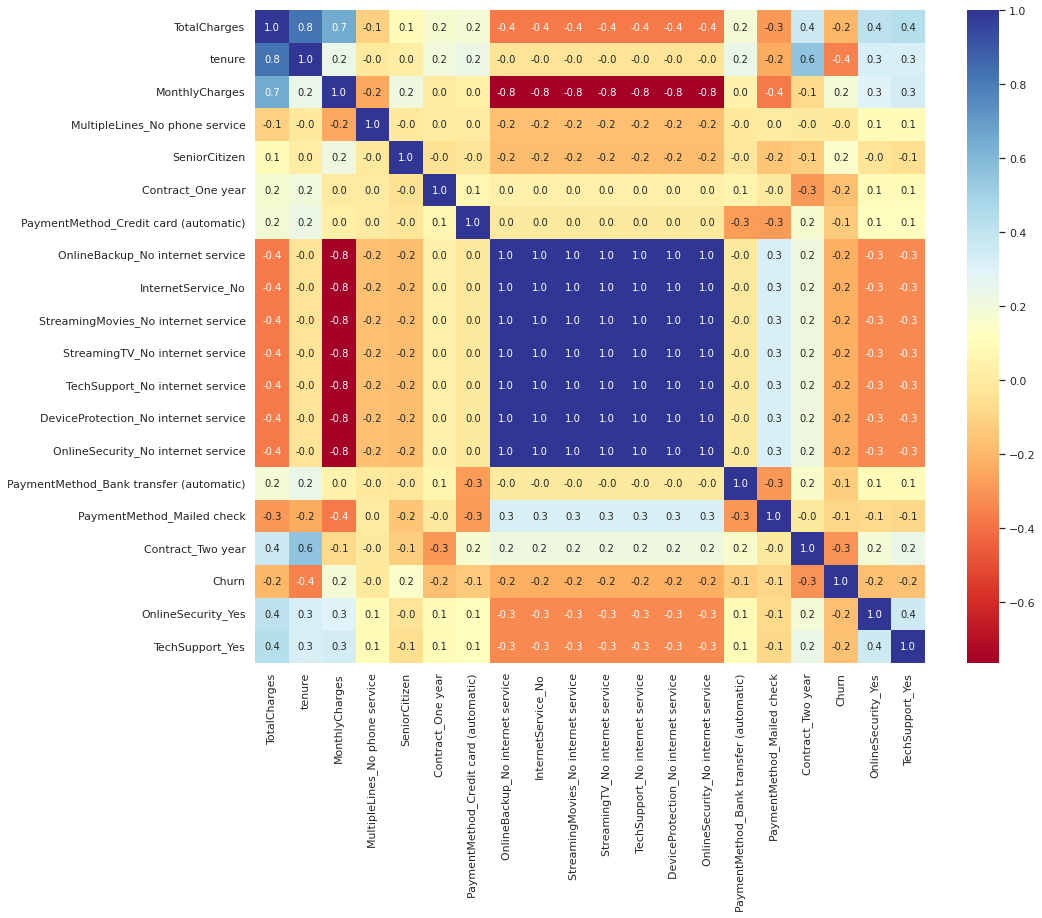

In [118]:
plt.figure(figsize = (15, 12))
sns.heatmap(new_df.corr(), cmap="RdYlBu", annot=True, fmt=".1f")
plt.show()

In [119]:
hightly_corr_feature = ["OnlineBackup_No internet service", "StreamingMovies_No internet service", "StreamingTV_No internet service", 
"TechSupport_No internet service", "DeviceProtection_No internet service", "OnlineSecurity_No internet service"]

def remove_corr_features(features):
    for feature in features:
        del new_df[feature]

In [120]:
remove_corr_features(hightly_corr_feature)

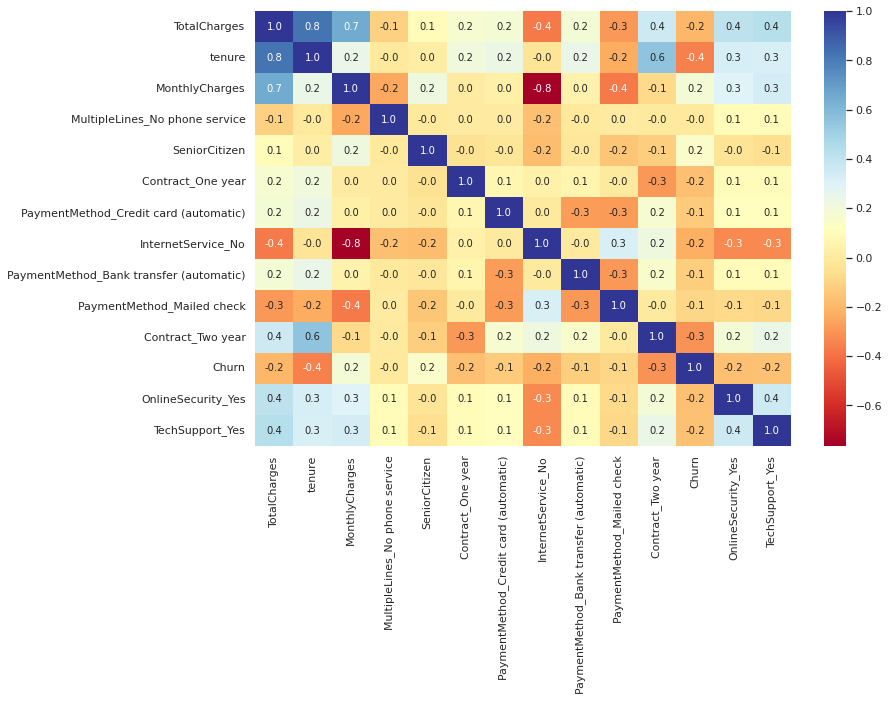

In [121]:
plt.figure(figsize = (12, 8))
sns.heatmap(new_df.corr(), cmap="RdYlBu", annot=True, fmt=".1f")
plt.show()

## Boxplot For Outlier Detection

In [122]:
trace = []

def gen_boxplot(df):
    for feature in df:
        trace.append(
            go.Box(
                name = feature,
                y = df[feature]
            )
        )
        
gen_boxplot(new_df)


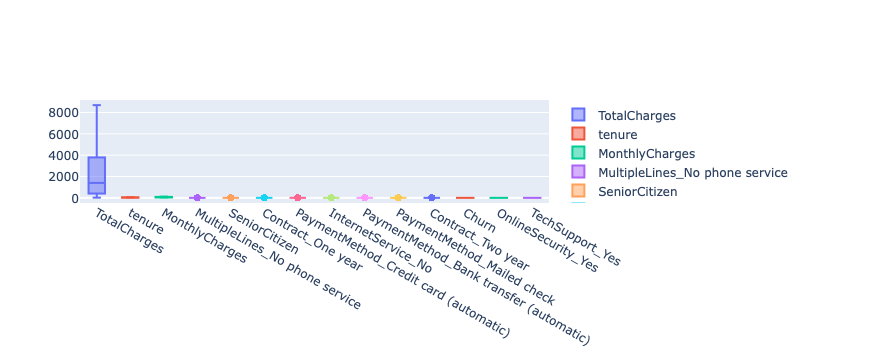

In [123]:
data = trace
plotly.offline.iplot(data)

#### Note: you can interect with the boxplot. So play around with it. Double click to back on initial state.
This plot is generated by using plotly. I have one interactive tutorial on plotly, you may visit those kernel:



## Data Visualization

#### Chrun percent

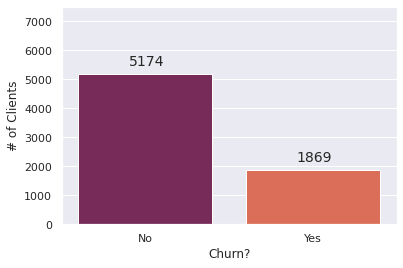

In [140]:
plt.figure(figsize=(6,4))

ax = sns.countplot(x="Churn", data=new_df, palette="rocket")

plt.xlabel("Churn?", fontsize= 12)
plt.ylabel("# of Clients", fontsize= 12)
plt.ylim(0,7500)
plt.xticks([0,1], ['No', 'Yes'], fontsize = 11)

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.30, p.get_height()+300), fontsize = 14)
    
plt.show()

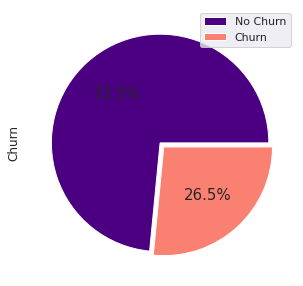

In [138]:

plt.figure(figsize=(7,5))

new_df['Churn'].value_counts().plot(kind='pie',labels = ['',''], autopct='%1.1f%%', colors = ['indigo','salmon'], explode = [0,0.05], textprops = {"fontsize":15})

plt.legend(labels=['No Churn', 'Churn'])
plt.show()

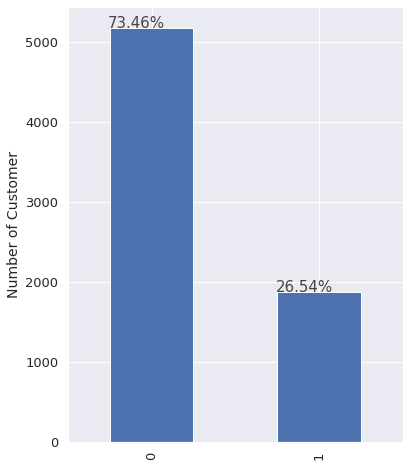

In [124]:
ax = new_df["Churn"].value_counts().plot(kind='bar', figsize=(6, 8), fontsize=13)
ax.set_ylabel("Number of Customer", fontsize=14);

totals = []
for i in ax.patches:
    totals.append(i.get_height())

total = sum(totals)

for i in ax.patches:
    ax.text(i.get_x() - .01, i.get_height() + .5, \
            str(round((i.get_height()/total)*100, 2))+'%', fontsize=15,
                color='#444444')
plt.show()

In [125]:
new_df.columns

Index(['TotalCharges', 'tenure', 'MonthlyCharges',
       'MultipleLines_No phone service', 'SeniorCitizen', 'Contract_One year',
       'PaymentMethod_Credit card (automatic)', 'InternetService_No',
       'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Mailed check',
       'Contract_Two year', 'Churn', 'OnlineSecurity_Yes', 'TechSupport_Yes'],
      dtype='object')

In [126]:
new_df["tenure"].unique()

array([ 1,  4, 17, 22, 70, 32, 13,  3, 12, 63, 34, 42, 24, 16, 18, 14, 66,
       58, 48,  9, 50,  8, 72, 30, 28, 71, 10, 36, 59, 49, 41, 27, 60, 40,
       37,  2,  7, 62, 68, 35, 23, 43, 65, 52, 11, 26, 69, 38, 45, 20, 53,
       19, 54,  5, 46, 51, 64, 56, 15, 57,  6, 33, 67, 25, 61, 21, 31, 44,
       47, 55, 39, 29,  0])

<AxesSubplot:xlabel='MonthlyCharges', ylabel='tenure'>

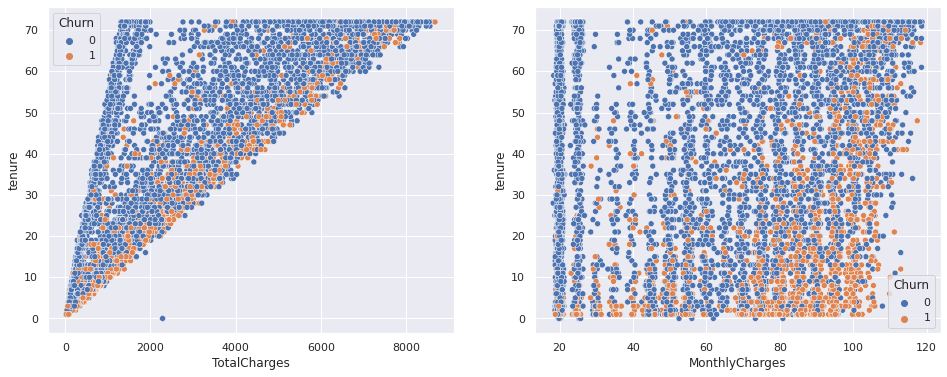

In [127]:
_, ax = plt.subplots(1, 2, figsize= (16, 6))
sns.scatterplot(x="TotalCharges", y = "tenure" , hue="Churn", data=new_df, ax=ax[0])
sns.scatterplot(x="MonthlyCharges", y = "tenure" , hue="Churn", data=new_df, ax=ax[1])

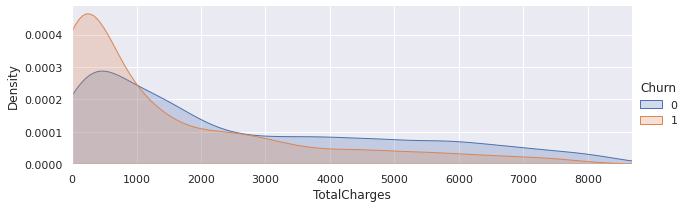

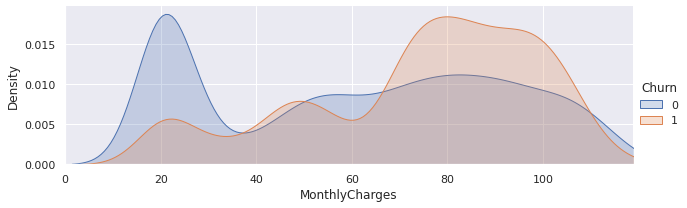

In [128]:
facet = sns.FacetGrid(new_df, hue = "Churn", aspect = 3)
facet.map(sns.kdeplot,"TotalCharges",shade= True)
facet.set(xlim=(0, new_df["TotalCharges"].max()))
facet.add_legend()

facet = sns.FacetGrid(new_df, hue = "Churn", aspect = 3)
facet.map(sns.kdeplot,"MonthlyCharges",shade= True)
facet.set(xlim=(0, new_df["MonthlyCharges"].max()))
facet.add_legend()

<AxesSubplot:xlabel='Churn', ylabel='MonthlyCharges'>

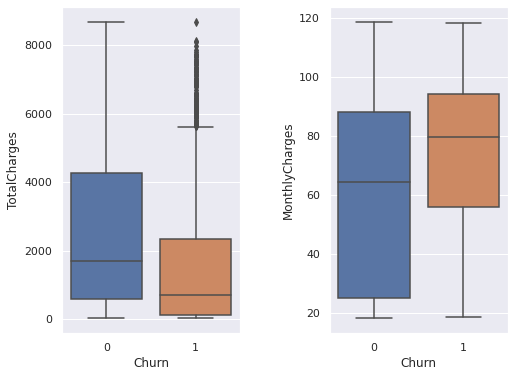

In [129]:
_, ax = plt.subplots(1, 2, figsize= (8, 6))
plt.subplots_adjust(wspace = 0.5)
sns.boxplot(x = 'Churn',  y = 'TotalCharges', data = new_df, ax=ax[0])
sns.boxplot(x = 'Churn',  y = 'MonthlyCharges', data = new_df, ax=ax[1])

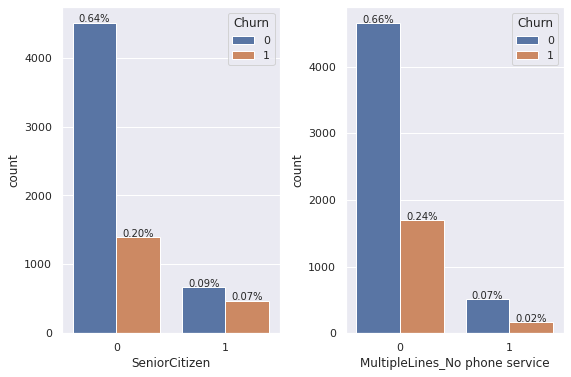

In [130]:
_, axs = plt.subplots(1, 2, figsize=(9, 6))
plt.subplots_adjust(wspace = 0.3)
ax = sns.countplot(data = new_df, x = "SeniorCitizen", hue = "Churn", ax = axs[0])
ax1 = sns.countplot(data = new_df, x = "MultipleLines_No phone service", hue = "Churn", ax = axs[1])

for p in ax.patches:
        height = p.get_height() 
        ax.text(
                p.get_x()+p.get_width()/2,
                height + 3.4,
                "{:1.2f}%".format(height/len(new_df),0),
                ha = "center", rotation = 0
               ) 
        
for p in ax1.patches:
        height = p.get_height() 
        ax1.text(
                p.get_x()+p.get_width()/2,
                height + 3.4,
                "{:1.2f}%".format(height/len(new_df),0),
                ha = "center", rotation = 0
               ) 

#### Senior Citizens customer are trends to Churn more than other

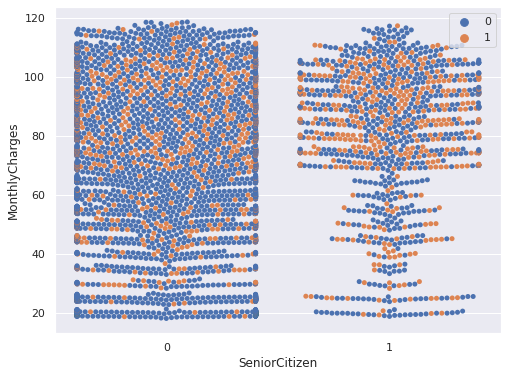

In [131]:
plt.figure(figsize=(8, 6))
sns.swarmplot(x = 'SeniorCitizen', y = 'MonthlyCharges', hue="Churn", data = new_df)
plt.legend(loc='upper right')

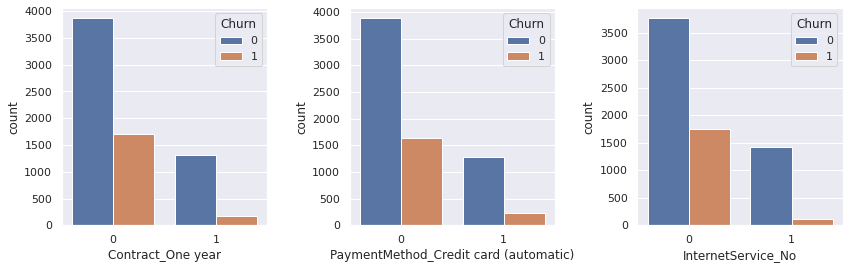

In [132]:
fig, ax = plt.subplots(1,3, figsize=(14, 4))
plt.subplots_adjust(wspace=0.4)
sns.countplot(x = "Contract_One year", hue="Churn" , ax=ax[0], data=new_df)
sns.countplot(data = new_df, x = "PaymentMethod_Credit card (automatic)", ax=ax[1], hue="Churn")
sns.countplot(data = new_df, x ="InternetService_No", ax=ax[2], hue="Churn")
fig.show()

<AxesSubplot:xlabel='Contract_Two year', ylabel='TotalCharges'>

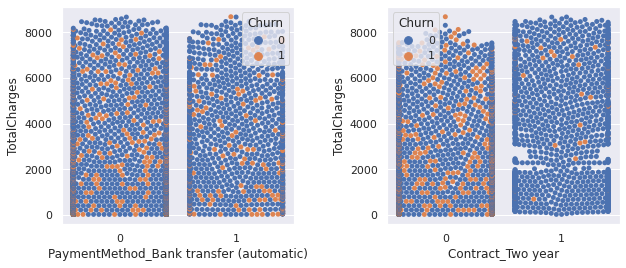

In [133]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))
plt.subplots_adjust(wspace=0.4)
sns.swarmplot(x = 'PaymentMethod_Bank transfer (automatic)', y = 'TotalCharges', hue="Churn", data = new_df, ax=ax[0])
sns.swarmplot(x = 'Contract_Two year', y = 'TotalCharges', hue="Churn", data = new_df, ax=ax[1])

#### Customer with less than 2 years contract are more often churn

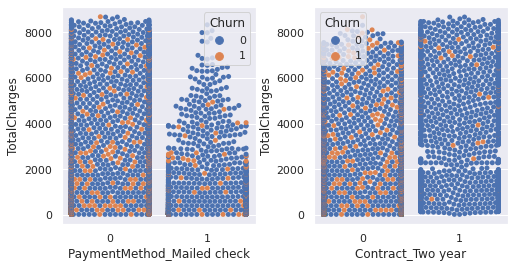

In [134]:
fig, ax = plt.subplots(1,2, figsize=(8, 4))
plt.subplots_adjust(wspace=0.3)
sns.swarmplot(x = 'PaymentMethod_Mailed check', y = 'TotalCharges', hue="Churn", data = new_df, ax=ax[0])
sns.swarmplot(x = 'Contract_Two year', y = 'TotalCharges', hue="Churn", data = new_df, ax=ax[1])
fig.show()

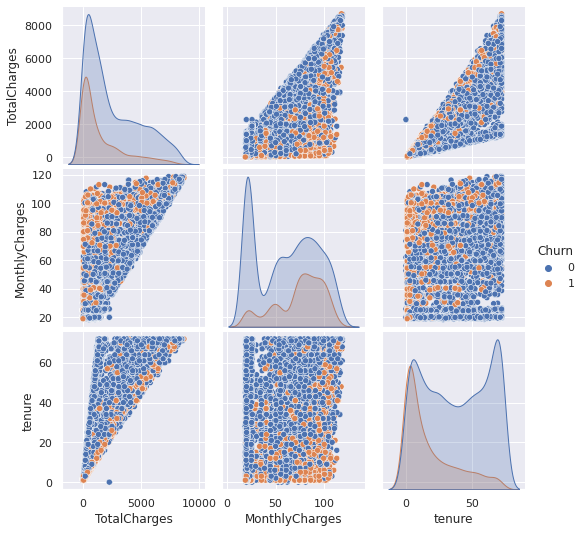

In [135]:
cols = ["TotalCharges", "MonthlyCharges", "tenure", "Churn"] 
pairplot_feature = new_df[cols]
sns.pairplot(pairplot_feature, hue = "Churn")

## finding important features via random forest methods

In [136]:
X = new_df.drop("Churn", axis=1)
y = new_df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
clf = RandomForestClassifier(random_state=0).fit(X_train, y_train)

In [137]:
perm = PermutationImportance(clf, random_state = 1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0348 ± 0.0077,tenure
0.0310 ± 0.0120,MonthlyCharges
0.0156 ± 0.0073,Contract_One year
0.0143 ± 0.0069,TechSupport_Yes
0.0108 ± 0.0049,Contract_Two year
0.0086 ± 0.0051,InternetService_No
0.0084 ± 0.0047,OnlineSecurity_Yes
0.0035 ± 0.0069,PaymentMethod_Bank transfer (automatic)
0.0030 ± 0.0051,SeniorCitizen
0.0010 ± 0.0031,MultipleLines_No phone service
